<a href="https://colab.research.google.com/github/rsoaresp/bandits_notebooks/blob/master/thompson_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on [this nice tutorial](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf) from Stanford.

In [0]:
from typing import *

import numpy as np
from numpy.random import beta, random, randint, choice

from matplotlib.pylab import plt

In [0]:
class Bernoulli:
  """A very simple Bernoulli bandit, with rewards given by {0, 1}."""

  def __init__(self, num_arms: int, arms_probabilities: List[float]):

    self.num_arms = num_arms
    self.arms_probabilities = arms_probabilities

  def reward(self, arm_number: int) -> float:
    return 1.0 if random() < self.arms_probabilities[arm_number] else 0.0

In [0]:
class ThompsonSampling:
  
  def __init__(self, num_steps: int):
    self.num_steps = num_steps

  def run_sim(self, bandit: Bernoulli) -> np.array:

    reward = np.zeros(self.num_steps)
    chosen_arm = np.zeros(self.num_steps, dtype=int)
    arms_probs = np.ones((self.num_steps, bandit.num_arms))/bandit.num_arms
  
    beta_parameters = [(1, 1) for i in range(0, bandit.num_arms)]

    for i in range(0, self.num_steps):

      success_draws = np.array([beta(*param) for param in beta_parameters])
      
      chosen_arm[i] = choice(np.where(success_draws == success_draws.max())[0])
      reward[i] = bandit.reward(chosen_arm[i])

      updated_param = (beta_parameters[chosen_arm[i]][0] + reward[i],
                       beta_parameters[chosen_arm[i]][1] + 1 - reward[i])

      beta_parameters[chosen_arm[i]] = updated_param
      arms_probs[i,:] = self.calculate_arms_probabilities(beta_parameters)

    return reward, arms_probs, chosen_arm

  def calculate_arms_probabilities(self, beta_parameters):
    return [parameter[0]/sum(parameter) for parameter in beta_parameters]

In [0]:
class Plot:

  def __init__(self, ax):
    self.ax = ax
    self.alg = ThompsonSampling(1000)

    self.reward = np.zeros(1000)
    self.probs = np.zeros((1000, 3))

    self.arms = {i: np.zeros(1000) for i in range(0, 3)}

  def __call__(self, num_runs: int):

    for i in range(0, num_runs):
      b = Bernoulli(3, [0.9, 0.8, 0.7])
      
      r, p, a = self.alg.run_sim(b)

      self.reward += r
      self.probs += p/num_runs

      for key in self.arms.keys():
        self.arms[key] += (a == key)/num_runs

    ax[0].plot(self.reward/num_runs, 'k-')

    plt.grid(True)
    plt.ylabel(r'$\langle$ reward $\rangle$', fontsize = 18)

    for j in range(0, 3):
      ax[1].plot([self.probs[i, j] for i in range(0, 1000)], 'k-')

    for key in self.arms:
      ax[2].plot(self.arms[key], label=f'action {key}', lw = 2)

    plt.grid(True)
    plt.ylabel(r'probabilities of taking each action', fontsize = 16)  
    ax[2].legend(loc=0, fancybox=True, shadow=True, fontsize=18)

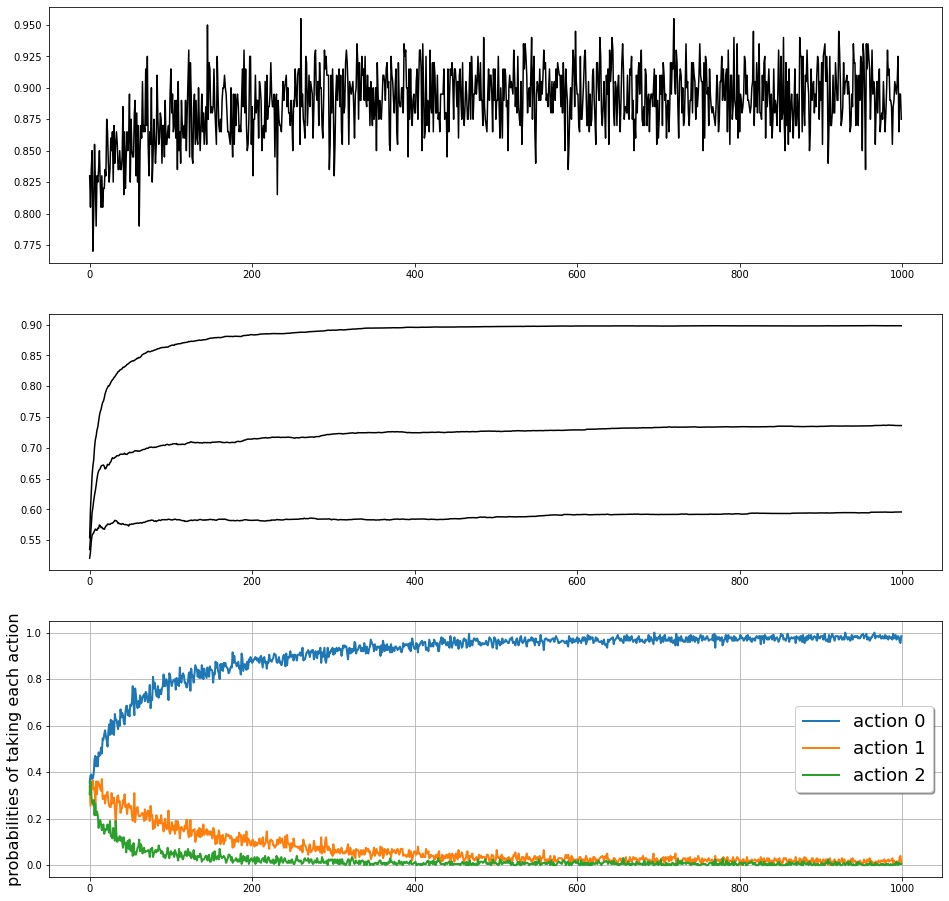

In [5]:
fig, ax = plt.subplots(figsize = (16, 16), ncols=1, nrows=3)
Plot(ax)(200)